In [60]:
from __future__ import division,print_function
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import os
import matplotlib
import numpy as np
import random
from numpy import linalg as LA
from PIL import Image
import sys
import itertools
from skimage import filters
from scipy import ndimage
from sklearn.model_selection import train_test_split  
from sklearn.svm import SVC 
from sklearn.metrics import classification_report, confusion_matrix ,accuracy_score
from skimage import color
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import accuracy_score
import re
import warnings
from scipy.spatial import distance
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
import argparse
import os
import sys
from moviepy.editor import VideoFileClip
import numpy as np
import scipy.misc
from tqdm import tqdm
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model

In [61]:
warnings.filterwarnings('ignore')

# Function which creates features using CNN

In [64]:
def crop_center(im):

    h, w = im.shape[0], im.shape[1]

    if h < w:
        return im[0:h,int((w-h)/2):int((w-h)/2)+h,:]
    else:
        return im[int((h-w)/2):int((h-w)/2)+w,0:w,:]
    
def is_video(x):
    return x.endswith('.mp4') or x.endswith('.avi') or x.endswith('.mov')

def extract_features(input_dir, output_dir, model_type='inceptionv3', batch_size=32):
    
    input_dir = os.path.expanduser(input_dir)
    output_dir = os.path.expanduser(output_dir)

    if not os.path.isdir(input_dir):
        sys.stderr.write("Input directory '%s' does not exist!\n" % input_dir)
        sys.exit(1)

    model = None
    input_shape = (224, 224)

    if model_type.lower() == 'inceptionv3':
        from keras.applications import InceptionV3
        model = InceptionV3(include_top=True, weights='imagenet')
    elif model_type.lower() == 'xception':
        from keras.applications import Xception
        model = Xception(include_top=True, weights='imagenet')
    elif model_type.lower() == 'resnet50':
        from keras.applications import ResNet50
        model = ResNet50(include_top=True, weights='imagenet')
    elif model_type.lower() == 'vgg16':
        from keras.applications import VGG16
        model = VGG16(include_top=True, weights='imagenet')
    elif model_type.lower() == 'vgg19':
        from keras.applications import VGG19
        model = VGG19(include_top=True, weights='imagenet')
    else:
        sys.stderr.write("'%s' is not a valid ImageNet model.\n" % model_type)
        sys.exit(1)

    if model_type.lower() == 'inceptionv3' or model_type.lower() == 'xception':
        shape = (299, 299)

    
    model = Model(model.inputs, output=model.layers[-2].output)

    visual_dir = os.path.join(output_dir, 'visual') 
    for directory in [visual_dir]:
        if not os.path.exists(directory):
            os.makedirs(directory)


    vis_existing = [x.split('.')[0] for x in os.listdir(visual_dir)]


    video_filenames = [x for x in sorted(os.listdir(input_dir))
                       if is_video(x) and os.path.splitext(x)[0] not in vis_existing]

    for video_filename in tqdm(video_filenames):
        try:
            clip = VideoFileClip( os.path.join(input_dir, video_filename) )
        except Exception as e:
            sys.stderr.write("Unable to read '%s'. Skipping...\n" % video_filename)
            sys.stderr.write("Exception: {}\n".format(e))
            continue

        fps = int( np.round(clip.fps) )
        frames = [scipy.misc.imresize(crop_center(x.astype(np.float32)), shape)
                  for idx, x in enumerate(clip.iter_frames()) if idx % fps == fps//2]


        n_frames = len(frames)

        frames_arr = np.empty((n_frames,)+shape+(3,), dtype=np.float32)
        for idx, frame in enumerate(frames):
            frames_arr[idx,:,:,:] = frame

        frames_arr = preprocess_input(frames_arr)

        features = model.predict(frames_arr, batch_size=batch_size)

        name, _ = os.path.splitext(video_filename)
        feat_filepath = os.path.join(visual_dir, name+'.npy')

        with open(feat_filepath, 'wb') as f:
            np.save(f, features)
        clip.reader.close()

In [65]:
extract_features(input_dir="./data", output_dir="./data",model_type="inceptionv3", batch_size=32)


  8%|██████▊                                                                          | 67/800 [03:13<35:42,  2.92s/it]


 17%|█████████████▌                                                                  | 135/800 [06:18<31:59,  2.89s/it]


 25%|████████████████████▎                                                           | 203/800 [09:44<28:34,  2.87s/it]


 34%|███████████████████████████                                                     | 271/800 [12:57<23:28,  2.66s/it]


 42%|█████████████████████████████████▉                                              | 339/800 [15:56<19:57,  2.60s/it]


 51%|████████████████████████████████████████▋                                       | 407/800 [19:07<20:14,  3.09s/it]


 59%|███████████████████████████████████████████████▌                                | 475/800 [22:28<12:57,  2.39s/it]


 68%|██████████████████████████████████████████████████████▎                         | 543/800 [26:24<12:47,  2.99s/it]


 76%|█████████████████████████████████████████████████████████████                   | 611/800 [29:34<08:29,  2.70s/it]


 85%|███████████████████████████████████████████████████████████████████▉            | 679/800 [32:48<06:07,  3.04s/it]


 93%|██████████████████████████████████████████████████████████████████████████▋     | 747/800 [36:11<02:51,  3.23s/it]


100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [38:53<00:00,  3.10s/it]

# SVM

# Weizmann dataset

In [69]:
classes = ['bend','jack','jump','pjump','run','side','skip','walk','wave']
dataset = []
label = []
for root, dirs, files in os.walk('./WeizzmanDataset/features'):
    for file in files:
        a = np.load(root+'/'+file)
        a = a.flatten()
        s = file.split('_')[1].split('.')[0]
        label.append(classes.index(re.sub('[^a-zA-Z]','',s)))
        dataset.append(a.tolist())
minn = sys.maxsize
for i in dataset:
    minn = min(len(i),minn)
minn
for i in range(len(dataset)):
    dataset[i] = dataset[i][:minn]
df = pd.DataFrame(dataset)
X = df.copy()  
Y = label[:]
X['mean'] = X.sum(axis=1)/len(list(X))
for i in list(X):
    if i == 'mean':
        continue
    X[i] = X[i] - X['mean']
X = X.drop('mean', axis=1)  

In [70]:
number_of_experiment = 10
avg_acc = 0
for i in range(number_of_experiment):
    print('Expirement No :',i+1)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30) 
    svclassifier = SVC(kernel='linear')  
    svclassifier.fit(X_train, y_train)
    print('Training Set Size : ',len(y_train),'Testing Set Size :',len(y_test))
    y_pred = svclassifier.predict(X_test) 
    print()
    avg_acc += accuracy_score(y_test, y_pred)
    print('Accuracy :',accuracy_score(y_test, y_pred)*100)
    print()
    print(confusion_matrix(y_test,y_pred))  
    print()
    print(classification_report(y_test,y_pred)) 
    print()
print('Average Accuracy :',(avg_acc/number_of_experiment)*100)

Expirement No : 1
Training Set Size :  65 Testing Set Size : 28

Accuracy : 32.142857142857146

[[1 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 3]
 [0 0 0 0 1 0 0 2 0]
 [0 0 1 0 0 0 0 0 2]
 [0 0 0 0 0 0 2 1 0]
 [1 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 2 2 0]
 [0 1 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 5]]

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         3
           5       1.00      0.33      0.50         3
           6       0.40      0.50      0.44         4
           7       0.00      0.00      0.00         2
           8       0.50      1.00      0.67         5

   micro avg       0.32      0.32      0.32        28
   macro avg       0.27      0.26      0.23        28
weighted avg       0.29      0.32      0.27        28


Expirem



Expirement No : 10
Training Set Size :  65 Testing Set Size : 28

Accuracy : 32.142857142857146

[[2 0 0 0 0 0 0 0 2]
 [0 0 0 1 1 0 0 0 1]
 [0 0 1 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 1]
 [0 1 0 1 1 0 0 0 0]
 [0 0 0 0 2 0 0 1 0]
 [0 0 1 0 1 0 0 1 0]
 [0 0 0 0 2 0 0 0 0]
 [0 1 0 1 0 0 0 0 4]]

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.00      0.00      0.00         3
           2       0.50      1.00      0.67         1
           3       0.25      0.33      0.29         3
           4       0.14      0.33      0.20         3
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         2
           8       0.50      0.67      0.57         6

   micro avg       0.32      0.32      0.32        28
   macro avg       0.27      0.31      0.27        28
weighted avg       0.31      0.32      0.29        28


Aver

# KTH Dataset

In [71]:
classes = ['boxing','handclapping','jogging','running','walking','handwaving']
dataset = []
label = []
for root, dirs, files in os.walk('./KTHDataset/features'):
    for file in files:
        a = np.load(root+'/'+file)
        a = a.flatten()
        label.append(classes.index(file.split('_')[1]))
        dataset.append(a.tolist())
minn = sys.maxsize
for i in dataset:
    minn = min(len(i),minn)
minn
for i in range(len(dataset)):
    dataset[i] = dataset[i][:minn]
df = pd.DataFrame(dataset)
X = df.copy()  
Y = label[:]
X['mean'] = X.sum(axis=1)/len(list(X))
for i in list(X):
    if i == 'mean':
        continue
    X[i] = X[i] - X['mean']
X = X.drop('mean', axis=1)  

In [72]:
number_of_experiment = 10
avg_acc = 0
for i in range(number_of_experiment):
    print('Expirement No :',i+1)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30) 
    svclassifier = SVC(kernel='linear')  
    svclassifier.fit(X_train, y_train)
    print('Training Set Size : ',len(y_train),'Testing Set Size :',len(y_test))
    y_pred = svclassifier.predict(X_test) 
    print()
    avg_acc += accuracy_score(y_test, y_pred)
    print('Accuracy :',accuracy_score(y_test, y_pred)*100)
    print()
    print(confusion_matrix(y_test,y_pred))  
    print()
    print(classification_report(y_test,y_pred)) 
    print()
print('Average Accuracy :',(avg_acc/number_of_experiment)*100)

Expirement No : 1
Training Set Size :  375 Testing Set Size : 162

Accuracy : 54.93827160493827

[[20  5  0  0  0  7]
 [ 6  8  0  0  0  7]
 [ 0  0 20 13  7  0]
 [ 0  2 10 17  1  0]
 [ 0  1  5  0 14  0]
 [ 3  6  0  0  0 10]]

              precision    recall  f1-score   support

           0       0.69      0.62      0.66        32
           1       0.36      0.38      0.37        21
           2       0.57      0.50      0.53        40
           3       0.57      0.57      0.57        30
           4       0.64      0.70      0.67        20
           5       0.42      0.53      0.47        19

   micro avg       0.55      0.55      0.55       162
   macro avg       0.54      0.55      0.54       162
weighted avg       0.56      0.55      0.55       162


Expirement No : 2
Training Set Size :  375 Testing Set Size : 162

Accuracy : 58.0246913580247

[[16  4  0  0  0  4]
 [ 4 13  0  0  0  8]
 [ 1  0 16  6  6  0]
 [ 1  0 14 19  2  1]
 [ 1  0 10  2 12  0]
 [ 3  1  0  0  0 18]]

       

# Moments In Time

In [67]:
classes = ['ascending','assembling','baking','barbecuing','bending','bicycling','biting','boating']
dataset = []
label = []
for root, dirs, files in os.walk('./MomentsInTime/visual'):
    for file in files:
        a = np.load(root+'/'+file)
        a = a.flatten()
        label.append(classes.index(re.sub('[^a-zA-Z]','',file.split('.')[0])))
        dataset.append(a.tolist())
minn = sys.maxsize
for i in dataset:
    minn = min(len(i),minn)
minn
for i in range(len(dataset)):
    dataset[i] = dataset[i][:minn]
df = pd.DataFrame(dataset)
X = df.copy()  
Y = label[:]
X['mean'] = X.sum(axis=1)/len(list(X))
for i in list(X):
    if i == 'mean':
        continue
    X[i] = X[i] - X['mean']
X = X.drop('mean', axis=1)  

In [73]:
number_of_experiment = 10
avg_acc = 0
for i in range(number_of_experiment):
    print('Expirement No :',i+1)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30) 
    svclassifier = SVC(kernel='linear')  
    svclassifier.fit(X_train, y_train)
    print('Training Set Size : ',len(y_train),'Testing Set Size :',len(y_test))
    y_pred = svclassifier.predict(X_test) 
    print()
    avg_acc += accuracy_score(y_test, y_pred)
    print('Accuracy :',accuracy_score(y_test, y_pred)*100)
    print()
    print(confusion_matrix(y_test,y_pred))  
    print()
    print(classification_report(y_test,y_pred)) 
    print()
print('Average Accuracy :',(avg_acc/number_of_experiment)*100)

Expirement No : 1
Training Set Size :  375 Testing Set Size : 162

Accuracy : 51.23456790123457

[[22  8  0  0  0  0]
 [ 9 11  0  0  0  9]
 [ 0  0 21  7  5  0]
 [ 1  0 11 13  0  0]
 [ 3  2 11  0  7  0]
 [ 4  9  0  0  0  9]]

              precision    recall  f1-score   support

           0       0.56      0.73      0.64        30
           1       0.37      0.38      0.37        29
           2       0.49      0.64      0.55        33
           3       0.65      0.52      0.58        25
           4       0.58      0.30      0.40        23
           5       0.50      0.41      0.45        22

   micro avg       0.51      0.51      0.51       162
   macro avg       0.53      0.50      0.50       162
weighted avg       0.52      0.51      0.50       162


Expirement No : 2
Training Set Size :  375 Testing Set Size : 162

Accuracy : 59.25925925925925

[[28  4  0  0  0  2]
 [ 4 15  0  0  0  9]
 [ 0  0 16  6  6  0]
 [ 1  0  6 17  5  0]
 [ 0  0 11  0 10  0]
 [ 5  7  0  0  0 10]]

      

# Data Visualization

In [215]:
X = []
XX = []
cap = cv2.VideoCapture("person01_walking_d1_uncomp.avi")

ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255

while(1):
    ret, frame2 = cap.read()
    if not ret: break
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
    
    flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    X.append(next)
    
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    o = cv2.cvtColor(rgb,cv2.COLOR_BGR2GRAY)
    XX.append(o)
    frame2 = cv2.Laplacian(frame2,cv2.CV_64F)
    cv2.imshow('frame2',o)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    elif k == ord('s'):
        cv2.imwrite('opticalfb.png',frame2)
        cv2.imwrite('opticalhsv.png',rgb)
    prvs = next

cap.release()
cv2.destroyAllWindows()
X = np.array(X)
XX = np.array(XX)
print(X.shape)
print(XX.shape)
lXX = []
lX = []
for i in range(len(XX)):
    lXX.append(cv2.Canny(XX[i],100,200))
    lX.append(cv2.Canny(X[i],100,200))
lXX = np.array(lXX)
lX = np.array(lX)

(554, 120, 160)
(554, 120, 160)


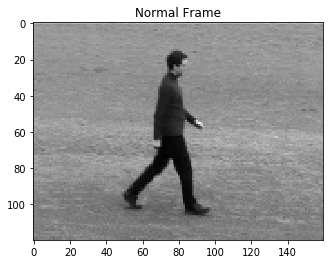

In [250]:
plt.imshow(X[187],'gray')
plt.title('Normal Frame')
plt.savefig('normal_frame.png')
plt.show()

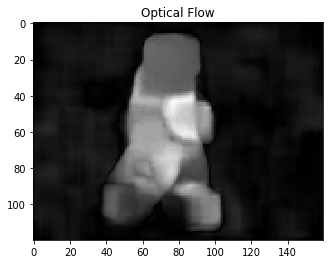

In [251]:
plt.imshow(XX[187],'gray')
plt.title('Optical Flow')
plt.savefig('optical_flow.png')
plt.show()

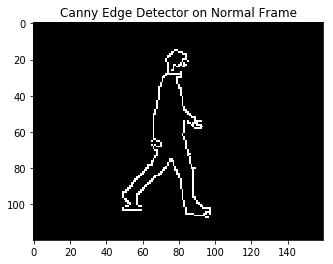

In [252]:
plt.imshow(lX[187],'gray')
plt.title('Canny Edge Detector on Normal Frame')
plt.savefig('canny_edge_normal_frame.png')
plt.show()

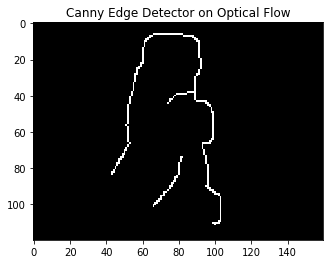

In [253]:
plt.imshow(lXX[187],'gray')
plt.title('Canny Edge Detector on Optical Flow')
plt.savefig('canny_edge_optical_flow.png')
plt.show()

In [206]:
lX[lX<0]=0
lXX[lXX<0]=0

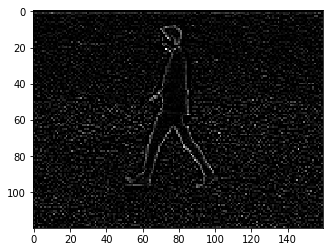

In [207]:
plt.imshow(lX[37],'gray')
plt.show()

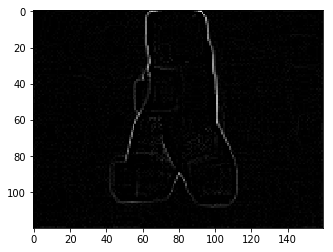

In [208]:
plt.imshow(lXX[37],'gray')
plt.show()

# Frame File

In [2]:
file = open('KTHDataset/00sequences.txt', 'r') 
name = 'frames'
lines = file.readlines()
d = {}
for i in lines:
    if name in i:
        s = i.split("\t")
        p = s[0]
        k = s.index('frames')
        a = np.array([])
        s = s[k+1].split(',')
        for i in range(0,len(s)):
            a = np.append(a,np.arange(int(s[i].split('-')[0]),int(s[i].split('-')[1])))
        d[p.strip()] = a

# Reading Data

In [255]:
def read_data(directory,count):
    dataset = []
    label = []
    for root, dirs, files in os.walk(directory):
        ext = ['.avi']
        if not (root == directory):
            key = root.split('\\')[1]
        c = count
        for name in files:
            filename, file_extension = os.path.splitext(name)

            if file_extension not in ext:
                continue
            if True:
                print(directory+'/'+key+'/'+name)
                XX = []
                X = []
                cap = cv2.VideoCapture(directory+'/'+key+'/'+name)
                ret, frame1 = cap.read()
                prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
                hsv = np.zeros_like(frame1)
                hsv[...,1] = 255
                frame_n = 1
                while(1):
                    ret, frame2 = cap.read()
                    if not ret: 
                        break
                    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
                    flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
                    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
                    hsv[...,0] = ang*180/np.pi/2
                    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
                    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
                    o = cv2.cvtColor(rgb,cv2.COLOR_BGR2GRAY)
                    if frame_n in d[re.sub('_uncomp','', filename)]:
                        XX.append(o)
                        X.append(next)
                    frame_n += 1
                    prvs = next
                cap.release()
                cv2.destroyAllWindows()
                XX = np.array(XX)
                X = np.array(X)
                lXX = []
                lX = []
                for i in range(len(XX)):
                    lXX.append(cv2.Canny(XX[i],100,200))
                    lX.append(cv2.Canny(X[i],100,200))
                lXX = np.array(lXX)
                lX = np.array(lX)
                z = []
                lXX[lXX<0]=0
                for i in range(len(lXX)):
                    z.append((i,np.count_nonzero(lXX[i])))  
                z.sort(key=lambda x: x[1],reverse=True)
                z = z[0:150]
                zz = []
                for i in z:
                    zz.append(i[0])
                zz.sort()
                f = []
                for i in range(len(lXX)):
                    if i in zz:
                        f.append(cv2.resize(lXX[i],(50,50)))
                f = np.array(f)
                f = f.flatten()
                f = f[np.nonzero(f)]
                print(f.shape)
                dataset.append(f)
                label.append(key)
                c -=1
            if c == 0:
                break
    return dataset,label

In [53]:
directory = './KTHDataset'
count = 1
dataset,label = read_data(directory,count)

./KTHDataset/boxing/person01_boxing_d1_uncomp.avi
(7202,)
./KTHDataset/handclapping/person01_handclapping_d1_uncomp.avi
(7480,)
./KTHDataset/handwaving/person01_handwaving_d1_uncomp.avi
(9732,)
./KTHDataset/jogging/person01_jogging_d1_uncomp.avi
(13328,)
./KTHDataset/running/person01_running_d1_uncomp.avi
(7727,)
./KTHDataset/walking/person01_walking_d1_uncomp.avi
(12972,)


# L1-PCA

In [141]:
def l1pca_SBF_rank1_simplified(dfX,L):
    N = len(dfX.T) #Number of data points
    max_iter = 100 #Number of iteration    
    delta = [0] * N #array to store quadratic value
    obj_val = 0 #initialize the objective function's value ||X*b||_2^2
    
    for i in range(0,L): #loop through initializations
        b = np.random.choice([0, 1], size=(N,), p=[1./3, 2./3])* 2 - 1;
        dfb = pd.DataFrame(b)
        print('Initializtion : ',i)
        j = 0
        for j in range(0,max_iter): #loop of iterations for bit flipping
            for k in list(dfX): #loop over N bits in b
                dfbk = dfb.copy()
                dfXk = dfX.copy()
                dfbk = dfbk.drop([k])
                dfXk = dfXk.drop([k],axis=1)
                tmp = pd.DataFrame(dfX.loc[:,k])
                tmp = tmp.apply(lambda x: x*dfb.loc[k][0])
                tmp = tmp.T.dot(dfXk.dot(dfbk))
                delta[k] = -4 * list(tmp[list(tmp)[0]])[0] #calculate the "increase of the objective function" after flipping the i-th bit 
            ID = sorted(range(len(delta)), key=lambda g: delta[g],reverse = True) #sort delta and find the bit that leads to the highest increase
            val = np.sort(delta)[::-1]
            
            if val[0] > 0: #if the highest "increase" is positive
                b[ID[0]] = -b[ID[0]] #then flip the corresponding bit in b
            else:
                break #otherwise, SBF terminates
        tmp = LA.norm(dfX.dot(dfb)) #calculate the  objective function's value
        if tmp > obj_val: #if larger than the old obj function value
            obj_val = tmp
            bopt = b #then update the obj function value, and the optimal b
            l_best = i
    dfbopt = pd.DataFrame(bopt)
    Qprop = dfX.dot(dfbopt)/LA.norm(dfX.dot(dfbopt)) #PCA X*bopt/norm(X*bopt)
    Bprop = dfbopt
    return Qprop,Bprop,l_best,j

# Greedy Algorithm

In [59]:
def greedy_algorithm_find_k_principal_component(trainingSet,number_of_principal_component,number_of_initialization):
    QrL1 = pd.DataFrame()
    for principal_component_i in range(1,number_of_principal_component+1):
        print('Principal Component: ',principal_component_i)
        Qprop,Bprop,l_best,iteration = l1pca_SBF_rank1_simplified(trainingSet,number_of_initialization)
        QrL1[str(principal_component_i)] = Qprop[0].values
        print('Best Initialization :',l_best,'\t','Iteration :',iteration)
        trainingSet = trainingSet - QrL1[[str(principal_component_i)]].dot(QrL1[[str(principal_component_i)]].T.dot(trainingSet))
    print()
    return QrL1

# Nearest Neighbor

In [190]:
def NearestNeighbor(testSet,QrL1,number_of_principal_component,trainingSet,trainingLabel,testinglabel):
    accuracy = []
    d = {}
    for principal_component_i in range(1,number_of_principal_component+1):
        labels = []
        print('Principal_Component :',principal_component_i)
        testingImages = list(testSet.T)
        for i in testingImages:
            error = sys.maxsize
            min_error = sys.maxsize
            test_label = -1
            true_label = testinglabel[testingImages.index(i)]
            trainingImages = list(trainingSet.T)
            for j in trainingImages:
                number_of_components = []
                for component_i in range(1,principal_component_i+1):
                    number_of_components.append(str(component_i))
                error =  distance.euclidean(QrL1[number_of_components].T.dot(trainingSet.loc[j]),QrL1[number_of_components].T.dot(testSet.loc[i]))
                if error < min_error:
                    min_error = error
                    test_label = trainingLabel[trainingImages.index(j)]
            image_label = []
            image_label.append(true_label)
            image_label.append(test_label)
            labels.append(image_label)
        accurate = 0
        for label in labels:
            if label[0] == label[1]:
                accurate += 1
        
        d[principal_component_i] = [accurate,len(testSet)]
        print('Accuracy :',round(((accurate/len(list(testSet)))*100),2),'\t','Error :',round((((len(list(testSet))-accurate)/len(list(testSet)))*100),2))
        print()
        
    
    return d

In [142]:
number_of_principal_component = 6
number_of_initailization = 10
QrL1 = greedy_algorithm_find_k_principal_component(X.T,number_of_principal_component,number_of_initailization)

Principal Component:  1
Initializtion :  0
Initializtion :  1
Initializtion :  2
Initializtion :  3
Initializtion :  4
Initializtion :  5
Initializtion :  6
Initializtion :  7
Initializtion :  8
Initializtion :  9
Best Initialization : 0 	 Iteration : 18
Principal Component:  2
Initializtion :  0
Initializtion :  1
Initializtion :  2
Initializtion :  3
Initializtion :  4
Initializtion :  5
Initializtion :  6
Initializtion :  7
Initializtion :  8
Initializtion :  9
Best Initialization : 0 	 Iteration : 29
Principal Component:  3
Initializtion :  0
Initializtion :  1
Initializtion :  2
Initializtion :  3
Initializtion :  4
Initializtion :  5
Initializtion :  6
Initializtion :  7
Initializtion :  8
Initializtion :  9
Best Initialization : 0 	 Iteration : 28
Principal Component:  4
Initializtion :  0
Initializtion :  1
Initializtion :  2
Initializtion :  3
Initializtion :  4
Initializtion :  5
Initializtion :  6
Initializtion :  7
Initializtion :  8
Initializtion :  9
Best Initialization :

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30) 

In [191]:
NearestNeighbor(X_test,QrL1,6,X_train,y_train,y_test)

Principal_Component : 1
Accuracy : 0.02 	 Error : 99.98

Principal_Component : 2
Accuracy : 0.02 	 Error : 99.98

Principal_Component : 3
Accuracy : 0.02 	 Error : 99.98

Principal_Component : 4
Accuracy : 0.02 	 Error : 99.98

Principal_Component : 5
Accuracy : 0.02 	 Error : 99.98

Principal_Component : 6
Accuracy : 0.02 	 Error : 99.98



{1: [4, 14], 2: [5, 14], 3: [4, 14], 4: [5, 14], 5: [5, 14], 6: [4, 14]}

# SVM

In [194]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20) 
for i in list(QrL1):
    a = []
    for j in range(1,int(i)+1):
        a.append(str(j))
    newX_train = QrL1[a].T.dot(X_train.T).T
    newX_test = QrL1[a].T.dot(X_test.T).T
    svclassifier = SVC(kernel='linear')  
    svclassifier.fit(newX_train, y_train)
    y_pred = svclassifier.predict(newX_test) 
    print('Principal Componenet :',i,'Accuracy',round(accuracy_score(y_test, y_pred)*100,2),'%')

Principal Componenet : 1 Accuracy 14.29 %
Principal Componenet : 2 Accuracy 21.43 %
Principal Componenet : 3 Accuracy 21.43 %
Principal Componenet : 4 Accuracy 28.57 %
Principal Componenet : 5 Accuracy 50.0 %
Principal Componenet : 6 Accuracy 35.71 %


# KTH Database

In [37]:
def crop_center(im):
    h, w = im.shape[0], im.shape[1]

    if h < w:
        return im[0:h,int((w-h)/2):int((w-h)/2)+h,:]
    else:
        return im[int((h-w)/2):int((h-w)/2)+w,0:w,:]
    
def is_video(x):
    return x.endswith('.mp4') or x.endswith('.avi') or x.endswith('.mov')

def extract_features(input_dir, output_dir, model_type='inceptionv3', batch_size=32):

    input_dir = os.path.expanduser(input_dir)
    output_dir = os.path.expanduser(output_dir)

    if not os.path.isdir(input_dir):
        sys.stderr.write("Input directory '%s' does not exist!\n" % input_dir)
        sys.exit(1)

    shape = (50, 50)

    visual_dir = os.path.join(output_dir, 'visual') # RGB features

    for directory in [visual_dir]:#, motion_dir, opflow_dir]:
        if not os.path.exists(directory):
            os.makedirs(directory)

    vis_existing = [x.split('.')[0] for x in os.listdir(visual_dir)]

    video_filenames = [x for x in sorted(os.listdir(input_dir))
                       if is_video(x) and os.path.splitext(x)[0] not in vis_existing]

    framess = []
    label = []
    for video_filename in tqdm(video_filenames):

        try:
            clip = VideoFileClip( os.path.join(input_dir, video_filename) )
        except Exception as e:
            sys.stderr.write("Unable to read '%s'. Skipping...\n" % video_filename)
            sys.stderr.write("Exception: {}\n".format(e))
            continue
        fps = int( np.round(clip.fps) )
        frames = [scipy.misc.imresize(crop_center(x.astype(np.float32)), shape)
                  for idx, x in enumerate(clip.iter_frames()) if idx % fps == fps//2]
        
        framess.append(frames)
        n_frames = len(frames)
        for i in range(n_frames):
            label.append(classes.index(video_filename.split('_')[1]))
        clip.reader.close()
    return framess,label

In [20]:
classes = ['boxing','handclapping','jogging','running','walking','handwaving']

In [38]:
d,label = extract_features(input_dir="./data", output_dir="./data",model_type="inceptionv3", batch_size=32)

100%|████████████████████████████████████████████████████████████████████████████████| 537/537 [04:26<00:00,  1.72it/s]


In [39]:
d = np.array(d)
k = []
for i in d:
    for j in i:
        k.append(j)
k = np.array(k)

In [44]:
def cnn(dataset,label,epochs):
    train_images, test_images, train_labels, test_labels = train_test_split(dataset, label, test_size = 0.30) 
    train_images = np.array(train_images)
    train_labels = np.array(train_labels)
    test_images = np.array(test_images)
    test_labels = np.array(test_labels)
#     class_names = {v: k for k, v in d.items()}
    train_images = train_images / 255.0
    test_images = test_images / 255.0
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(50, 50,3)),
        keras.layers.Dense(128, activation=tf.nn.relu),
        keras.layers.Dense(102, activation=tf.nn.softmax)
    ])
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    model.fit(train_images, train_labels, epochs=epochs)
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print('Test accuracy:', test_acc*100)

In [43]:
cnn(k,label,10)

Epoch 1/10
7101/7101 [==============================] - ETA: 3:30 - loss: 4.6772 - acc: 0.0000e+0 - ETA: 1:17 - loss: 4.6927 - acc: 0.0938    - ETA: 1:01 - loss: 4.7680 - acc: 0.093 - ETA: 44s - loss: 4.5159 - acc: 0.114 - ETA: 35s - loss: 5.0066 - acc: 0.13 - ETA: 30s - loss: 5.0205 - acc: 0.14 - ETA: 26s - loss: 5.0622 - acc: 0.14 - ETA: 24s - loss: 4.9023 - acc: 0.14 - ETA: 22s - loss: 4.6517 - acc: 0.15 - ETA: 21s - loss: 4.5368 - acc: 0.15 - ETA: 20s - loss: 4.2895 - acc: 0.16 - ETA: 18s - loss: 4.1921 - acc: 0.16 - ETA: 17s - loss: 4.0082 - acc: 0.17 - ETA: 17s - loss: 3.8667 - acc: 0.18 - ETA: 16s - loss: 3.7472 - acc: 0.18 - ETA: 16s - loss: 3.6816 - acc: 0.18 - ETA: 16s - loss: 3.6254 - acc: 0.18 - ETA: 15s - loss: 3.5718 - acc: 0.19 - ETA: 15s - loss: 3.4672 - acc: 0.19 - ETA: 15s - loss: 3.4167 - acc: 0.19 - ETA: 14s - loss: 3.3341 - acc: 0.19 - ETA: 14s - loss: 3.2526 - acc: 0.20 - ETA: 13s - loss: 3.1760 - acc: 0.20 - ETA: 13s - loss: 3.0990 - acc: 0.21 - ETA: 12s - loss: 

7101/7101 [==============================] - ETA: 10s - loss: 1.2973 - acc: 0.50 - ETA: 12s - loss: 1.3535 - acc: 0.42 - ETA: 11s - loss: 1.3776 - acc: 0.37 - ETA: 11s - loss: 1.3912 - acc: 0.35 - ETA: 10s - loss: 1.3625 - acc: 0.36 - ETA: 10s - loss: 1.3733 - acc: 0.38 - ETA: 10s - loss: 1.3486 - acc: 0.39 - ETA: 10s - loss: 1.3507 - acc: 0.38 - ETA: 10s - loss: 1.3640 - acc: 0.35 - ETA: 10s - loss: 1.3473 - acc: 0.36 - ETA: 10s - loss: 1.3429 - acc: 0.36 - ETA: 9s - loss: 1.3442 - acc: 0.3688 - ETA: 9s - loss: 1.3354 - acc: 0.379 - ETA: 9s - loss: 1.3506 - acc: 0.376 - ETA: 9s - loss: 1.3331 - acc: 0.381 - ETA: 9s - loss: 1.3297 - acc: 0.382 - ETA: 9s - loss: 1.3344 - acc: 0.383 - ETA: 9s - loss: 1.3268 - acc: 0.391 - ETA: 9s - loss: 1.3307 - acc: 0.390 - ETA: 9s - loss: 1.3323 - acc: 0.391 - ETA: 9s - loss: 1.3391 - acc: 0.389 - ETA: 8s - loss: 1.3648 - acc: 0.381 - ETA: 8s - loss: 1.3645 - acc: 0.385 - ETA: 8s - loss: 1.3868 - acc: 0.381 - ETA: 8s - loss: 1.3956 - acc: 0.376 - ETA:

7101/7101 [==============================] - ETA: 6s - loss: 1.5522 - acc: 0.250 - ETA: 9s - loss: 1.4479 - acc: 0.312 - ETA: 9s - loss: 1.3772 - acc: 0.350 - ETA: 9s - loss: 1.3592 - acc: 0.379 - ETA: 9s - loss: 1.3559 - acc: 0.399 - ETA: 8s - loss: 1.3360 - acc: 0.403 - ETA: 9s - loss: 1.3140 - acc: 0.411 - ETA: 9s - loss: 1.3211 - acc: 0.410 - ETA: 8s - loss: 1.3391 - acc: 0.402 - ETA: 9s - loss: 1.3403 - acc: 0.409 - ETA: 9s - loss: 1.3371 - acc: 0.412 - ETA: 9s - loss: 1.3418 - acc: 0.406 - ETA: 8s - loss: 1.3347 - acc: 0.410 - ETA: 8s - loss: 1.3193 - acc: 0.412 - ETA: 8s - loss: 1.3109 - acc: 0.410 - ETA: 8s - loss: 1.3070 - acc: 0.412 - ETA: 8s - loss: 1.3027 - acc: 0.415 - ETA: 8s - loss: 1.3024 - acc: 0.411 - ETA: 8s - loss: 1.2963 - acc: 0.413 - ETA: 8s - loss: 1.2952 - acc: 0.414 - ETA: 8s - loss: 1.2991 - acc: 0.412 - ETA: 8s - loss: 1.3052 - acc: 0.407 - ETA: 8s - loss: 1.3053 - acc: 0.405 - ETA: 7s - loss: 1.3079 - acc: 0.406 - ETA: 7s - loss: 1.3066 - acc: 0.408 - ETA: 

7101/7101 [==============================] - ETA: 10s - loss: 1.2897 - acc: 0.43 - ETA: 9s - loss: 1.2885 - acc: 0.3542 - ETA: 9s - loss: 1.3014 - acc: 0.381 - ETA: 9s - loss: 1.2862 - acc: 0.419 - ETA: 9s - loss: 1.2375 - acc: 0.447 - ETA: 9s - loss: 1.2452 - acc: 0.454 - ETA: 9s - loss: 1.2396 - acc: 0.447 - ETA: 9s - loss: 1.2259 - acc: 0.447 - ETA: 9s - loss: 1.2311 - acc: 0.435 - ETA: 9s - loss: 1.2398 - acc: 0.437 - ETA: 8s - loss: 1.2485 - acc: 0.431 - ETA: 8s - loss: 1.2404 - acc: 0.437 - ETA: 8s - loss: 1.2507 - acc: 0.428 - ETA: 8s - loss: 1.2530 - acc: 0.423 - ETA: 8s - loss: 1.2460 - acc: 0.428 - ETA: 8s - loss: 1.2592 - acc: 0.421 - ETA: 8s - loss: 1.2631 - acc: 0.422 - ETA: 8s - loss: 1.2713 - acc: 0.426 - ETA: 8s - loss: 1.2730 - acc: 0.425 - ETA: 8s - loss: 1.2700 - acc: 0.424 - ETA: 8s - loss: 1.2736 - acc: 0.421 - ETA: 8s - loss: 1.2695 - acc: 0.424 - ETA: 8s - loss: 1.2738 - acc: 0.421 - ETA: 7s - loss: 1.2769 - acc: 0.415 - ETA: 7s - loss: 1.2715 - acc: 0.414 - ETA:

7101/7101 [==============================] - ETA: 10s - loss: 1.1604 - acc: 0.50 - ETA: 10s - loss: 1.1925 - acc: 0.46 - ETA: 9s - loss: 1.2479 - acc: 0.3875 - ETA: 9s - loss: 1.2598 - acc: 0.379 - ETA: 9s - loss: 1.2444 - acc: 0.395 - ETA: 9s - loss: 1.2860 - acc: 0.383 - ETA: 9s - loss: 1.2603 - acc: 0.389 - ETA: 9s - loss: 1.2624 - acc: 0.387 - ETA: 9s - loss: 1.2412 - acc: 0.395 - ETA: 9s - loss: 1.2367 - acc: 0.388 - ETA: 8s - loss: 1.2333 - acc: 0.392 - ETA: 8s - loss: 1.2321 - acc: 0.403 - ETA: 8s - loss: 1.2296 - acc: 0.412 - ETA: 8s - loss: 1.2230 - acc: 0.418 - ETA: 8s - loss: 1.2316 - acc: 0.410 - ETA: 8s - loss: 1.2276 - acc: 0.422 - ETA: 8s - loss: 1.2275 - acc: 0.423 - ETA: 8s - loss: 1.2247 - acc: 0.428 - ETA: 8s - loss: 1.2208 - acc: 0.427 - ETA: 8s - loss: 1.2204 - acc: 0.429 - ETA: 8s - loss: 1.2208 - acc: 0.434 - ETA: 8s - loss: 1.2165 - acc: 0.436 - ETA: 7s - loss: 1.2158 - acc: 0.436 - ETA: 7s - loss: 1.2165 - acc: 0.437 - ETA: 7s - loss: 1.2196 - acc: 0.433 - ETA:

In [46]:

seed = 7
numpy.random.seed(seed)

train_images, test_images, train_labels, test_labels = train_test_split(k, label, test_size = 0.30) 
X_train = train_images
y_train = train_labels
X_test =  test_images
y_test = test_labels

X_train = X_train / 255.0
X_test = X_test / 255.0
number_of_classes = len(np.unique(label))
y_train = np_utils.to_categorical(y_train, number_of_classes)
y_test = np_utils.to_categorical(y_test, number_of_classes)

model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(X_train.shape[1], X_train.shape[2], 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(number_of_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200)


metrics = model.evaluate(X_test, y_test, verbose=0)
print("Metrics(Test loss & Test Accuracy): ")
print(metrics)

Train on 7101 samples, validate on 3044 samples
Epoch 1/10
7101/7101 [==============================] - ETA: 1:12 - loss: 1.7963 - acc: 0.180 - ETA: 56s - loss: 1.8078 - acc: 0.170 - ETA: 49s - loss: 1.7982 - acc: 0.17 - ETA: 44s - loss: 1.7963 - acc: 0.18 - ETA: 41s - loss: 1.7911 - acc: 0.18 - ETA: 39s - loss: 1.7839 - acc: 0.19 - ETA: 37s - loss: 1.7819 - acc: 0.19 - ETA: 35s - loss: 1.7748 - acc: 0.21 - ETA: 34s - loss: 1.7694 - acc: 0.22 - ETA: 32s - loss: 1.7628 - acc: 0.23 - ETA: 30s - loss: 1.7535 - acc: 0.24 - ETA: 29s - loss: 1.7437 - acc: 0.25 - ETA: 28s - loss: 1.7322 - acc: 0.27 - ETA: 26s - loss: 1.7208 - acc: 0.27 - ETA: 25s - loss: 1.7065 - acc: 0.28 - ETA: 24s - loss: 1.6950 - acc: 0.28 - ETA: 22s - loss: 1.6836 - acc: 0.29 - ETA: 21s - loss: 1.6698 - acc: 0.29 - ETA: 20s - loss: 1.6556 - acc: 0.30 - ETA: 18s - loss: 1.6426 - acc: 0.30 - ETA: 17s - loss: 1.6315 - acc: 0.30 - ETA: 16s - loss: 1.6204 - acc: 0.30 - ETA: 15s - loss: 1.6120 - acc: 0.30 - ETA: 14s - loss: 1.

# Weizzman Dataset

In [51]:
def crop_center(im):

    h, w = im.shape[0], im.shape[1]

    if h < w:
        return im[0:h,int((w-h)/2):int((w-h)/2)+h,:]
    else:
        return im[int((h-w)/2):int((h-w)/2)+w,0:w,:]
    
def is_video(x):
    return x.endswith('.mp4') or x.endswith('.avi') or x.endswith('.mov')

def extract_features(input_dir, output_dir, model_type='inceptionv3', batch_size=32):

    input_dir = os.path.expanduser(input_dir)
    output_dir = os.path.expanduser(output_dir)

    if not os.path.isdir(input_dir):
        sys.stderr.write("Input directory '%s' does not exist!\n" % input_dir)
        sys.exit(1)

    shape = (50, 50)


    visual_dir = os.path.join(output_dir, 'visual') # RGB features
 
    for directory in [visual_dir]:#, motion_dir, opflow_dir]:
        if not os.path.exists(directory):
            os.makedirs(directory)


    vis_existing = [x.split('.')[0] for x in os.listdir(visual_dir)]

    video_filenames = [x for x in sorted(os.listdir(input_dir))
                       if is_video(x) and os.path.splitext(x)[0] not in vis_existing]

    framess = []
    label = []
    for video_filename in tqdm(video_filenames):
        try:
            clip = VideoFileClip( os.path.join(input_dir, video_filename) )
        except Exception as e:
            sys.stderr.write("Unable to read '%s'. Skipping...\n" % video_filename)
            sys.stderr.write("Exception: {}\n".format(e))
            continue

        fps = int( np.round(clip.fps) )
        frames = [scipy.misc.imresize(crop_center(x.astype(np.float32)), shape)
                  for idx, x in enumerate(clip.iter_frames()) if idx % fps == fps//2]
        
        framess.append(frames)
        n_frames = len(frames)
        for i in range(n_frames):
            label.append(classes.index(re.sub('[^a-zA-Z]','',video_filename.split('_')[1].split('.')[0])))
        clip.reader.close()
    return framess,label

In [52]:
classes = ['bend','jack','jump','pjump','run','side','skip','walk','wave']

In [53]:
d,label = extract_features(input_dir="./WeizzmanDataset/videos", output_dir="./data",model_type="inceptionv3", batch_size=32)

100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [01:04<00:00,  1.57it/s]


In [54]:
d = np.array(d)
k = []
for i in d:
    for j in i:
        k.append(j)
k = np.array(k)

In [55]:
def cnn(dataset,label,epochs):
    train_images, test_images, train_labels, test_labels = train_test_split(dataset, label, test_size = 0.30) 
    train_images = np.array(train_images)
    train_labels = np.array(train_labels)
    test_images = np.array(test_images)
    test_labels = np.array(test_labels)
#     class_names = {v: k for k, v in d.items()}
    train_images = train_images / 255.0
    test_images = test_images / 255.0
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(50, 50,3)),
        keras.layers.Dense(128, activation=tf.nn.relu),
        keras.layers.Dense(102, activation=tf.nn.softmax)
    ])
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    model.fit(train_images, train_labels, epochs=epochs)
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print('Test accuracy:', test_acc*100)

In [58]:
cnn(k,label,30)

Epoch 1/30
159/159 [==============================] - ETA: 5s - loss: 4.9447 - acc: 0.0000e+0 - ETA: 1s - loss: 4.6802 - acc: 0.0781    - ETA: 0s - loss: 4.5249 - acc: 0.083 - ETA: 0s - loss: 4.7998 - acc: 0.062 - 2s 10ms/step - loss: 4.5880 - acc: 0.0818
Epoch 2/30
159/159 [==============================] - ETA: 0s - loss: 2.8527 - acc: 0.0000e+0 - ETA: 0s - loss: 3.0148 - acc: 0.0781    - ETA: 0s - loss: 2.9060 - acc: 0.145 - ETA: 0s - loss: 2.8946 - acc: 0.164 - 0s 2ms/step - loss: 2.8983 - acc: 0.1761
Epoch 3/30
159/159 [==============================] - ETA: 0s - loss: 2.8735 - acc: 0.062 - ETA: 0s - loss: 2.4246 - acc: 0.156 - ETA: 0s - loss: 2.3544 - acc: 0.145 - ETA: 0s - loss: 2.3649 - acc: 0.148 - 0s 2ms/step - loss: 2.3514 - acc: 0.1384
Epoch 4/30
159/159 [==============================] - ETA: 0s - loss: 2.3291 - acc: 0.187 - ETA: 0s - loss: 2.4152 - acc: 0.218 - ETA: 0s - loss: 2.2176 - acc: 0.242 - 0s 2ms/step - loss: 2.1982 - acc: 0.2453
Epoch 5/30
159/159 [=============

In [59]:
seed = 7
numpy.random.seed(seed)

train_images, test_images, train_labels, test_labels = train_test_split(k, label, test_size = 0.30) 
X_train = train_images
y_train = train_labels
X_test =  test_images
y_test = test_labels

X_train = X_train / 255.0
X_test = X_test / 255.0
number_of_classes = len(np.unique(label))
y_train = np_utils.to_categorical(y_train, number_of_classes)
y_test = np_utils.to_categorical(y_test, number_of_classes)

model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(X_train.shape[1], X_train.shape[2], 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(number_of_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200)

metrics = model.evaluate(X_test, y_test, verbose=0)
print("Metrics(Test loss & Test Accuracy): ")
print(metrics)

Train on 159 samples, validate on 69 samples
Epoch 1/10
159/159 [==============================] - 3s 21ms/step - loss: 2.2115 - acc: 0.1132 - val_loss: 2.2372 - val_acc: 0.1594
Epoch 2/10
159/159 [==============================] - 1s 9ms/step - loss: 2.1196 - acc: 0.2327 - val_loss: 2.2456 - val_acc: 0.1594
Epoch 3/10
159/159 [==============================] - 2s 10ms/step - loss: 2.0958 - acc: 0.2327 - val_loss: 2.2228 - val_acc: 0.1594
Epoch 4/10
159/159 [==============================] - 1s 9ms/step - loss: 2.0958 - acc: 0.2327 - val_loss: 2.2018 - val_acc: 0.1594
Epoch 5/10
159/159 [==============================] - 1s 9ms/step - loss: 2.0775 - acc: 0.2327 - val_loss: 2.1824 - val_acc: 0.1594
Epoch 6/10
159/159 [==============================] - 2s 10ms/step - loss: 2.0536 - acc: 0.2327 - val_loss: 2.1703 - val_acc: 0.1594
Epoch 7/10
159/159 [==============================] - 2s 10ms/step - loss: 2.0385 - acc: 0.2327 - val_loss: 2.1601 - val_acc: 0.1594
Epoch 8/10
159/159 [=======

# Moments In Time

In [90]:
def crop_center(im):

    h, w = im.shape[0], im.shape[1]

    if h < w:
        return im[0:h,int((w-h)/2):int((w-h)/2)+h,:]
    else:
        return im[int((h-w)/2):int((h-w)/2)+w,0:w,:]
    
def is_video(x):
    return x.endswith('.mp4') or x.endswith('.avi') or x.endswith('.mov')

def extract_features(input_dir, output_dir, model_type='inceptionv3', batch_size=32):

    input_dir = os.path.expanduser(input_dir)
    output_dir = os.path.expanduser(output_dir)

    if not os.path.isdir(input_dir):
        sys.stderr.write("Input directory '%s' does not exist!\n" % input_dir)
        sys.exit(1)

    shape = (50, 50)


    visual_dir = os.path.join(output_dir, 'visual') # RGB features
 
    for directory in [visual_dir]:#, motion_dir, opflow_dir]:
        if not os.path.exists(directory):
            os.makedirs(directory)


    vis_existing = [x.split('.')[0] for x in os.listdir(visual_dir)]

    video_filenames = [x for x in sorted(os.listdir(input_dir))
                       if is_video(x) and os.path.splitext(x)[0] not in vis_existing]
    framess = []
    label = []
    for video_filename in tqdm(video_filenames):
        try:
            clip = VideoFileClip( os.path.join(input_dir, video_filename) )
        except Exception as e:
            sys.stderr.write("Unable to read '%s'. Skipping...\n" % video_filename)
            sys.stderr.write("Exception: {}\n".format(e))
            continue

        fps = int( np.round(clip.fps) )
        frames = [scipy.misc.imresize(crop_center(x.astype(np.float32)), shape)
                  for idx, x in enumerate(clip.iter_frames()) if idx % fps == fps//2]
        
        framess.append(frames)
        n_frames = len(frames)
        for i in range(n_frames):
            label.append(classes.index(re.sub('[^a-zA-Z]','',video_filename.split('.')[0])))
        clip.reader.close()
    return framess,label

In [91]:
classes = ['ascending','assembling','baking','barbecuing','bending','bicycling','biting','boating']

In [93]:
d,label = extract_features(input_dir="./MomentsInTime/videos", output_dir="./data",model_type="inceptionv3", batch_size=32)


  8%|██████▊                                                                          | 67/800 [00:44<06:17,  1.94it/s]


 17%|█████████████▌                                                                  | 135/800 [01:32<09:14,  1.20it/s]


 25%|████████████████████▎                                                           | 203/800 [02:33<09:19,  1.07it/s]


 34%|███████████████████████████                                                     | 271/800 [03:43<15:50,  1.80s/it]


 42%|█████████████████████████████████▉                                              | 339/800 [04:51<06:53,  1.12it/s]


 51%|████████████████████████████████████████▋                                       | 407/800 [05:30<04:47,  1.37it/s]


 59%|███████████████████████████████████████████████▌                                | 475/800 [06:11<02:14,  2.42it/s]


 68%|██████████████████████████████████████████████████████▎                         | 543/800 [07:02<03:11,  1.35it/s]


 76%|█████████████████████████████████████████████████████████████                   | 611/800 [07:55<01:45,  1.79it/s]


 85%|███████████████████████████████████████████████████████████████████▉            | 679/800 [08:32<01:12,  1.67it/s]


 93%|██████████████████████████████████████████████████████████████████████████▋     | 747/800 [09:22<00:43,  1.22it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [10:00<00:00,  1.57it/s]

In [94]:
d = np.array(d)
k = []
for i in d:
    for j in i:
        k.append(j)
k = np.array(k)

In [95]:
def cnn(dataset,label,epochs):
    train_images, test_images, train_labels, test_labels = train_test_split(dataset, label, test_size = 0.30) 
    train_images = np.array(train_images)
    train_labels = np.array(train_labels)
    test_images = np.array(test_images)
    test_labels = np.array(test_labels)
#     class_names = {v: k for k, v in d.items()}
    train_images = train_images / 255.0
    test_images = test_images / 255.0
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(50, 50,3)),
        keras.layers.Dense(128, activation=tf.nn.relu),
        keras.layers.Dense(102, activation=tf.nn.softmax)
    ])
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    model.fit(train_images, train_labels, epochs=epochs)
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print('Test accuracy:', test_acc*100)

In [98]:
cnn(k,label,15)

Epoch 1/15
1680/1680 [==============================] - ETA: 5:03 - loss: 4.6577 - acc: 0.062 - ETA: 1:38 - loss: 3.7526 - acc: 0.104 - ETA: 1:13 - loss: 3.6137 - acc: 0.101 - ETA: 47s - loss: 3.2671 - acc: 0.104 - ETA: 40s - loss: 3.1208 - acc: 0.13 - ETA: 34s - loss: 3.0208 - acc: 0.14 - ETA: 30s - loss: 2.9600 - acc: 0.15 - ETA: 24s - loss: 2.8041 - acc: 0.17 - ETA: 21s - loss: 2.7739 - acc: 0.17 - ETA: 19s - loss: 2.7608 - acc: 0.18 - ETA: 16s - loss: 2.7563 - acc: 0.17 - ETA: 15s - loss: 2.7186 - acc: 0.17 - ETA: 14s - loss: 2.6731 - acc: 0.18 - ETA: 13s - loss: 2.6337 - acc: 0.19 - ETA: 12s - loss: 2.6261 - acc: 0.19 - ETA: 11s - loss: 2.6119 - acc: 0.19 - ETA: 10s - loss: 2.6070 - acc: 0.19 - ETA: 9s - loss: 2.5775 - acc: 0.2031 - ETA: 9s - loss: 2.5779 - acc: 0.207 - ETA: 8s - loss: 2.5613 - acc: 0.207 - ETA: 8s - loss: 2.5553 - acc: 0.207 - ETA: 7s - loss: 2.5369 - acc: 0.211 - ETA: 7s - loss: 2.5242 - acc: 0.215 - ETA: 6s - loss: 2.5101 - acc: 0.218 - ETA: 6s - loss: 2.5048 -

1680/1680 [==============================] - ETA: 3s - loss: 1.9103 - acc: 0.281 - ETA: 3s - loss: 1.8046 - acc: 0.343 - ETA: 3s - loss: 1.6301 - acc: 0.416 - ETA: 3s - loss: 1.5201 - acc: 0.429 - ETA: 3s - loss: 1.4970 - acc: 0.437 - ETA: 3s - loss: 1.4539 - acc: 0.458 - ETA: 3s - loss: 1.4713 - acc: 0.450 - ETA: 3s - loss: 1.5011 - acc: 0.445 - ETA: 3s - loss: 1.5054 - acc: 0.441 - ETA: 2s - loss: 1.4854 - acc: 0.459 - ETA: 2s - loss: 1.4704 - acc: 0.468 - ETA: 2s - loss: 1.4512 - acc: 0.479 - ETA: 2s - loss: 1.4720 - acc: 0.476 - ETA: 2s - loss: 1.4853 - acc: 0.471 - ETA: 2s - loss: 1.4700 - acc: 0.479 - ETA: 2s - loss: 1.4785 - acc: 0.474 - ETA: 2s - loss: 1.4703 - acc: 0.477 - ETA: 2s - loss: 1.4744 - acc: 0.480 - ETA: 2s - loss: 1.4782 - acc: 0.480 - ETA: 2s - loss: 1.4924 - acc: 0.473 - ETA: 2s - loss: 1.5037 - acc: 0.467 - ETA: 2s - loss: 1.5142 - acc: 0.468 - ETA: 2s - loss: 1.5111 - acc: 0.468 - ETA: 2s - loss: 1.5091 - acc: 0.466 - ETA: 2s - loss: 1.5047 - acc: 0.466 - ETA: 

1680/1680 [==============================] - ETA: 2s - loss: 1.3725 - acc: 0.531 - ETA: 2s - loss: 1.3398 - acc: 0.500 - ETA: 3s - loss: 1.2905 - acc: 0.510 - ETA: 2s - loss: 1.2192 - acc: 0.581 - ETA: 2s - loss: 1.3276 - acc: 0.536 - ETA: 2s - loss: 1.2945 - acc: 0.553 - ETA: 2s - loss: 1.2727 - acc: 0.554 - ETA: 2s - loss: 1.2999 - acc: 0.566 - ETA: 2s - loss: 1.2687 - acc: 0.575 - ETA: 2s - loss: 1.2541 - acc: 0.582 - ETA: 2s - loss: 1.2938 - acc: 0.570 - ETA: 2s - loss: 1.3223 - acc: 0.562 - ETA: 2s - loss: 1.3478 - acc: 0.546 - ETA: 2s - loss: 1.3346 - acc: 0.554 - ETA: 2s - loss: 1.3238 - acc: 0.556 - ETA: 2s - loss: 1.3322 - acc: 0.551 - ETA: 2s - loss: 1.3141 - acc: 0.559 - ETA: 2s - loss: 1.3144 - acc: 0.560 - ETA: 2s - loss: 1.3134 - acc: 0.560 - ETA: 2s - loss: 1.3171 - acc: 0.558 - ETA: 2s - loss: 1.3201 - acc: 0.552 - ETA: 2s - loss: 1.3069 - acc: 0.559 - ETA: 1s - loss: 1.3055 - acc: 0.559 - ETA: 1s - loss: 1.3120 - acc: 0.560 - ETA: 1s - loss: 1.3230 - acc: 0.552 - ETA: 

1680/1680 [==============================] - ETA: 3s - loss: 1.1083 - acc: 0.531 - ETA: 3s - loss: 1.1390 - acc: 0.531 - ETA: 3s - loss: 1.0476 - acc: 0.604 - ETA: 3s - loss: 1.0461 - acc: 0.601 - ETA: 3s - loss: 1.0883 - acc: 0.575 - ETA: 3s - loss: 1.1776 - acc: 0.557 - ETA: 3s - loss: 1.1508 - acc: 0.571 - ETA: 3s - loss: 1.1732 - acc: 0.570 - ETA: 3s - loss: 1.1774 - acc: 0.576 - ETA: 3s - loss: 1.1975 - acc: 0.571 - ETA: 3s - loss: 1.2292 - acc: 0.568 - ETA: 3s - loss: 1.2745 - acc: 0.567 - ETA: 3s - loss: 1.2963 - acc: 0.567 - ETA: 2s - loss: 1.2982 - acc: 0.564 - ETA: 2s - loss: 1.2857 - acc: 0.566 - ETA: 2s - loss: 1.2723 - acc: 0.572 - ETA: 2s - loss: 1.2663 - acc: 0.573 - ETA: 2s - loss: 1.2615 - acc: 0.572 - ETA: 2s - loss: 1.2442 - acc: 0.577 - ETA: 2s - loss: 1.2253 - acc: 0.585 - ETA: 2s - loss: 1.2354 - acc: 0.580 - ETA: 2s - loss: 1.2269 - acc: 0.583 - ETA: 2s - loss: 1.2204 - acc: 0.587 - ETA: 2s - loss: 1.2137 - acc: 0.591 - ETA: 2s - loss: 1.2135 - acc: 0.590 - ETA: 

In [97]:
seed = 7
numpy.random.seed(seed)

train_images, test_images, train_labels, test_labels = train_test_split(k, label, test_size = 0.30) 
X_train = train_images
y_train = train_labels
X_test =  test_images
y_test = test_labels

X_train = X_train / 255.0
X_test = X_test / 255.0
number_of_classes = len(np.unique(label))
y_train = np_utils.to_categorical(y_train, number_of_classes)
y_test = np_utils.to_categorical(y_test, number_of_classes)

model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(X_train.shape[1], X_train.shape[2], 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(number_of_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200)

metrics = model.evaluate(X_test, y_test, verbose=0)
print("Metrics(Test loss & Test Accuracy): ")
print(metrics)

Train on 1680 samples, validate on 720 samples
Epoch 1/10
1680/1680 [==============================] - ETA: 1:02 - loss: 2.1094 - acc: 0.130 - ETA: 31s - loss: 2.0854 - acc: 0.147 - ETA: 19s - loss: 2.0936 - acc: 0.15 - ETA: 13s - loss: 2.0887 - acc: 0.15 - ETA: 9s - loss: 2.0773 - acc: 0.1590 - ETA: 5s - loss: 2.0703 - acc: 0.170 - ETA: 3s - loss: 2.0599 - acc: 0.182 - ETA: 0s - loss: 2.0526 - acc: 0.188 - 22s 13ms/step - loss: 2.0483 - acc: 0.1940 - val_loss: 1.9744 - val_acc: 0.2389
Epoch 2/10
1680/1680 [==============================] - ETA: 10s - loss: 1.9073 - acc: 0.31 - ETA: 8s - loss: 1.9012 - acc: 0.3000 - ETA: 7s - loss: 1.9029 - acc: 0.281 - ETA: 5s - loss: 1.8918 - acc: 0.286 - ETA: 4s - loss: 1.8805 - acc: 0.281 - ETA: 3s - loss: 1.8628 - acc: 0.289 - ETA: 1s - loss: 1.8512 - acc: 0.300 - ETA: 0s - loss: 1.8503 - acc: 0.302 - 13s 8ms/step - loss: 1.8448 - acc: 0.3065 - val_loss: 1.8867 - val_acc: 0.2861
Epoch 3/10
1680/1680 [==============================] - ETA: 9s - los